In [1]:
# Fonots

# Használathoz fel kell tölteni a metric_____.log filét ha Google Colabon használod.

import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import pickle
import joblib

import warnings 
# warnings.filterwarnings("ignore")

from datetime import datetime, date, time

from tensorflow import keras
from tensorflow.keras import layers

from rich.progress import track

from termcolor import colored

from sklearn.linear_model import LinearRegression

from pandas.plotting import scatter_matrix

print(tf.__version__)

import time
ost = time.time()

ost = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
print(ost)

ost = time.strftime("%H:%M:%S", time.gmtime())
print(ost)

2023-05-09 18:13:33.763519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 18:13:33.968164: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-09 18:13:33.977149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-09 18:13:33.977172: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

2.10.0
2023-05-09 18:13:36
18:13:36


In [55]:
metric_file_name = './Train/Train10/metric_train_by_none.log'

df = pd.read_csv(metric_file_name, sep=',', header=0)

mf = df.copy()

mf['actual_vm_number_is'] = mf['worker_number']
mf['actual_vm_number_was'] = mf['worker_number'].shift(1)
mf['actual_vm_number_will'] = mf['worker_number'].shift(-1)

mf['delta_vm'] = mf['actual_vm_number_will'] - mf['actual_vm_number_is']

mf.head()

,worker_give_metrics,write_to_csv_time,time,response_time_p95,response_time,worker_number,request_rate,CPU0User%,CPU0Idle%,CPU0Total%,...,[NUMA:0]Hits,[TCPD]InReceives,[TCPD]InDelivers,[TCPD]OutRequests,[TCPD]InSegs,[TCPD]OutSegs,actual_vm_number_is,actual_vm_number_was,actual_vm_number_will,delta_vm
0,192.168.0.170,17:51:32,17:51:3,278.0805,241.023545,1,1.1,28.9,65.9,30.7,...,100.0,8.2,8.2,7.8,8.2,7.8,1,NaN,4.0,3.0
1,192.168.0.170,17:51:41,17:51:4,1466.2962,594.386100,4,1.0,15.5,79.0,17.7,...,100.0,5.7,5.7,5.2,5.7,5.3,4,1.0,1.0,-3.0
2,192.168.0.170,17:51:51,17:51:5,369.3555,255.753182,1,1.1,28.3,68.3,30.6,...,100.0,9.8,9.8,9.0,9.3,8.6,1,4.0,1.0,0.0
3,192.168.0.170,17:52:01,17:52:0,305.2375,225.374364,1,1.1,34.8,62.9,37.0,...,100.0,9.8,9.8,9.1,9.8,9.2,1,1.0,1.0,0.0
4,192.168.0.170,17:52:11,17:52:1,304.9632,230.918867,1,1.5,38.7,58.6,41.2,...,100.0,13.4,13.4,11.8,13.4,11.9,1,1.0,1.0,0.0


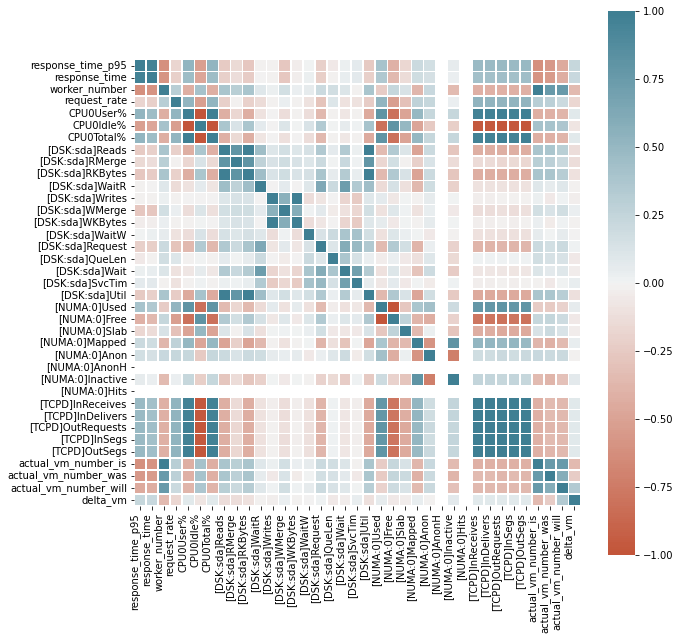

In [56]:
# Step 0 - Read the dataset, calculate column correlations and make a seaborn heatmap

corr = mf.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=False, linewidths=0.5, ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

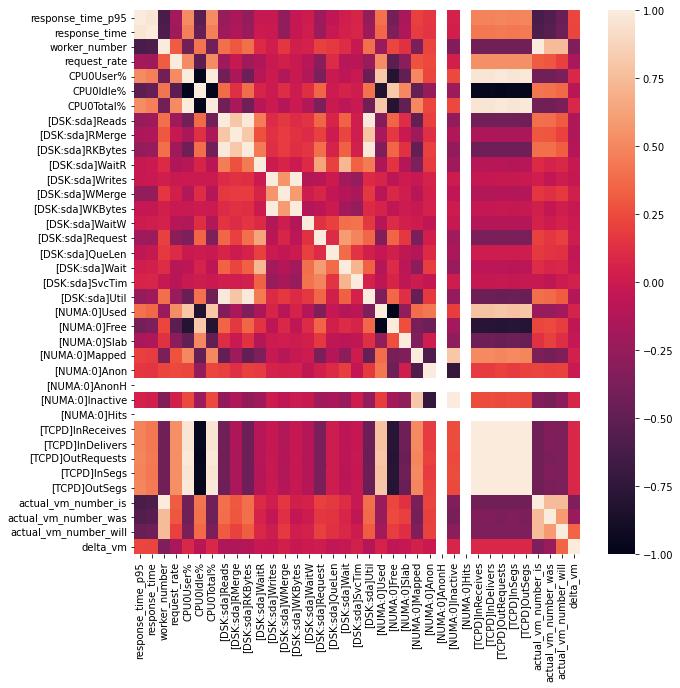

In [57]:
# plotting the heatmap for correlation
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(mf.corr(), annot=False)

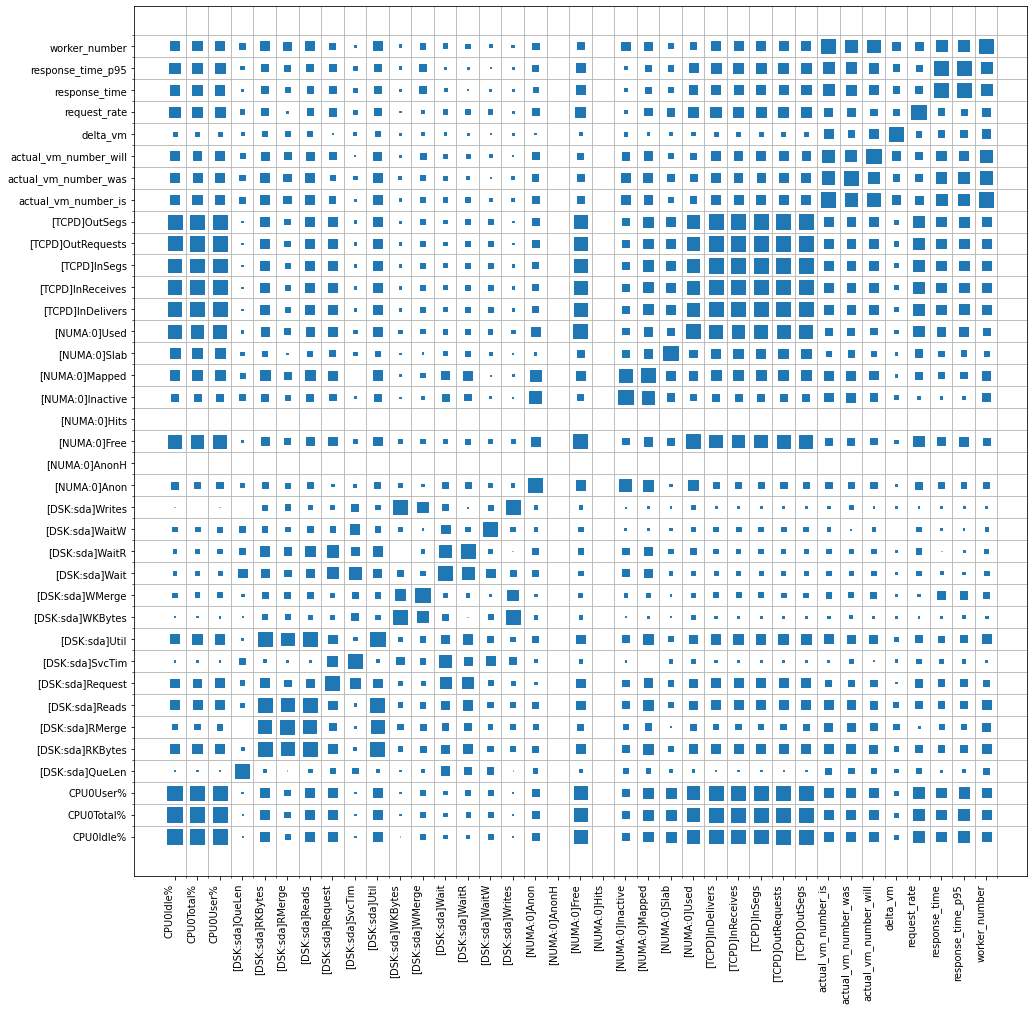

In [58]:
# Step 1 - Make a scatter plot with square markers, set column names as labels

def heatmap(x, y, size):
    fig, ax = plt.subplots(figsize=(16,16))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 200
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    # Add grid (matekfüzet)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    #
    # ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    # ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
data = pd.read_csv('https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv')
columns = ['bore', 'stroke', 'compression-ratio', 'horsepower', 'city-mpg', 'price']

data = mf
columns = mf.columns
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)



In [59]:
input_variables = ['CPU0User%', '[DSK:sda]WKBytes', 'request_rate', 'response_time', 'worker_number']

In [60]:
mf[input_variables].corr()

,CPU0User%,[DSK:sda]WKBytes,request_rate,response_time,worker_number
CPU0User%,1.000000,-0.008342,0.522957,0.465270,-0.428915
[DSK:sda]WKBytes,-0.008342,1.000000,-0.010021,-0.030679,0.035934
request_rate,0.522957,-0.010021,1.000000,-0.215475,0.319014
response_time,0.465270,-0.030679,-0.215475,1.000000,-0.589783
worker_number,-0.428915,0.035934,0.319014,-0.589783,1.000000


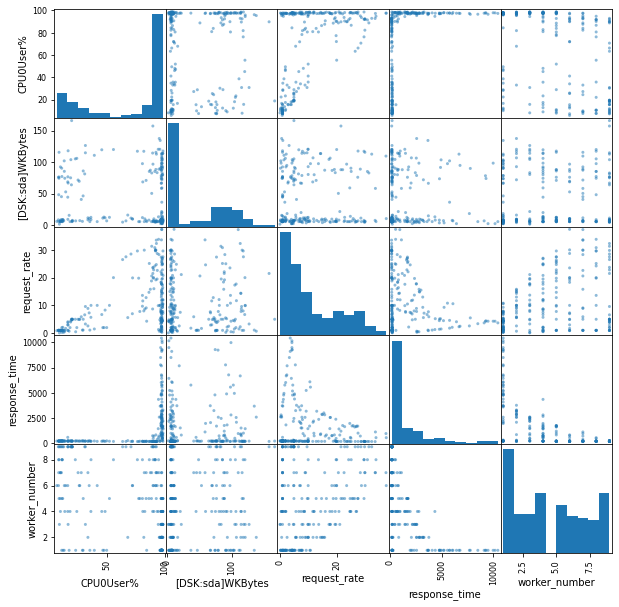

In [61]:
from pandas.plotting import scatter_matrix

scatter_matrix(mf[input_variables], figsize=(10,10))
plt.show()

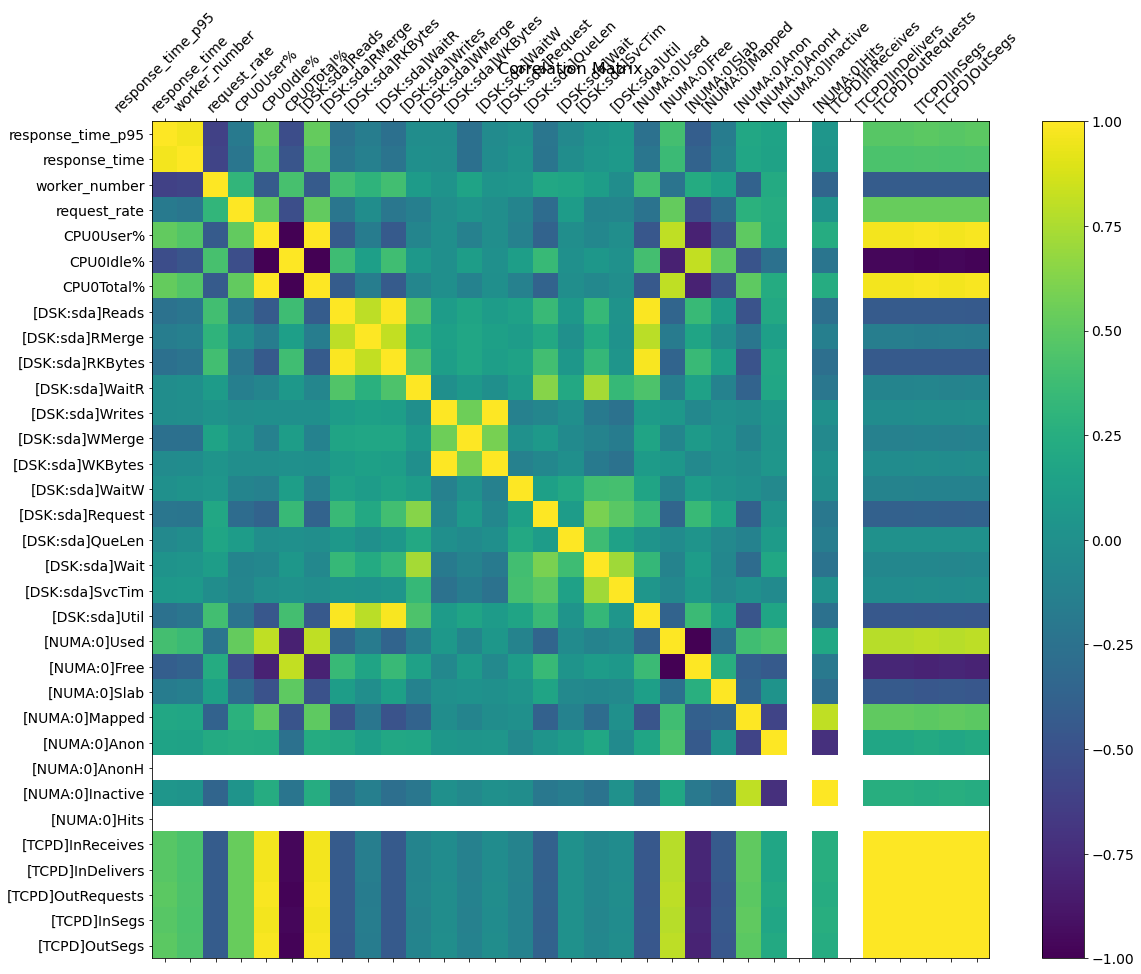

In [62]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

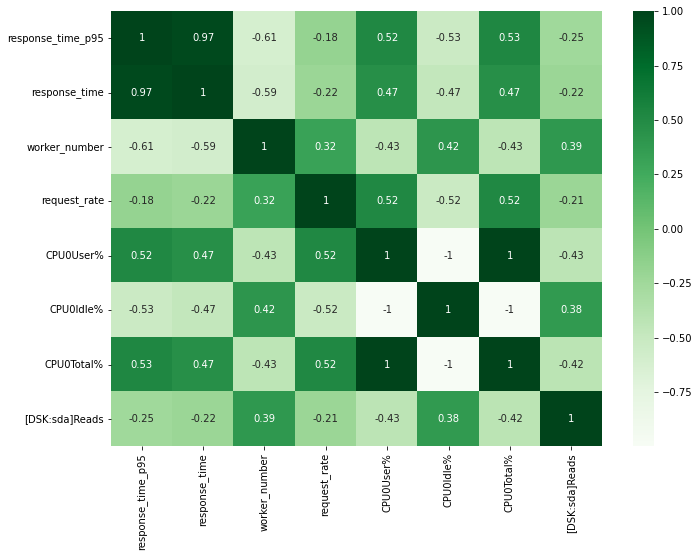

In [63]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(18, 18))
df= mf.iloc[: , [3,4,5,6,7,8,9,10,11,12,13,14,17]].copy()
df= mf.iloc[: , [3,4,5,6,7,8,9,10]].copy()
corr = df.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

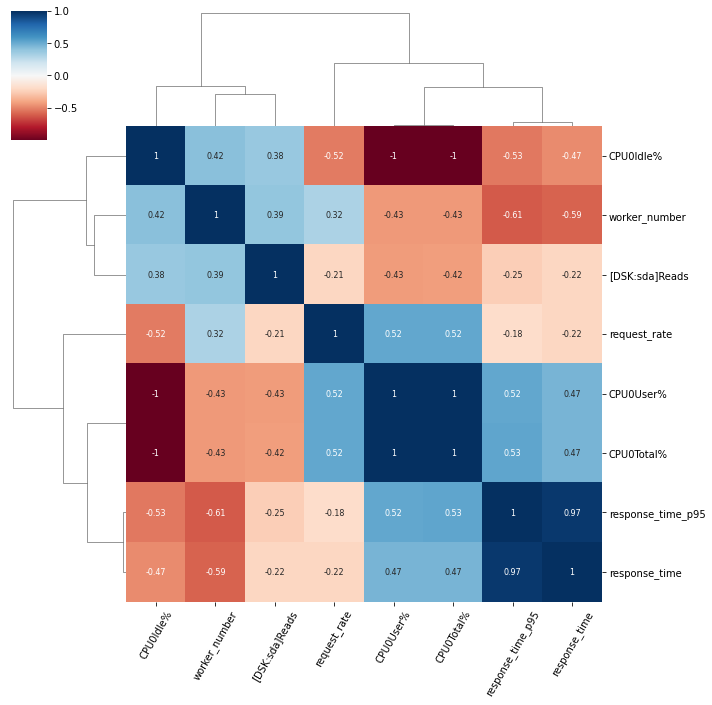

In [64]:
g = sns.clustermap(df.corr(), 
                   method = 'complete', 
                   cmap   = 'RdBu', 
                   annot  = True, 
                   annot_kws = {'size': 8})
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60);

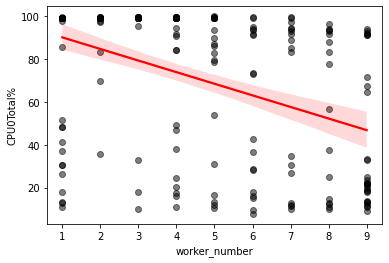

[]

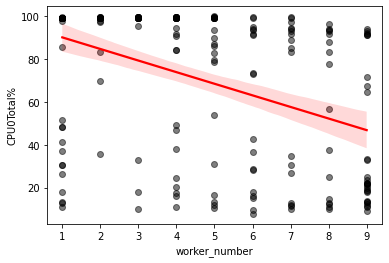

In [65]:
sns.regplot(x=mf['worker_number'],
            y=mf['CPU0Total%'],
            scatter_kws={
                "color": "black",
                "alpha": 0.5
            },
            line_kws={"color": "red"})
plt.show()

# ugyan az
sns.regplot(x='worker_number',
            y='CPU0Total%',
            data=mf,
            scatter_kws={
                "color": "black",
                "alpha": 0.5
            },
            line_kws={"color": "red"})
plt.plot()

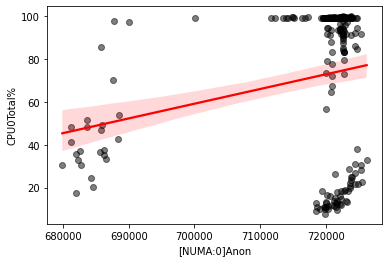

In [66]:
sns.regplot(x = mf['[NUMA:0]Anon'], y = mf['CPU0Total%'],
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"},
            ci = 95)
plt.show()

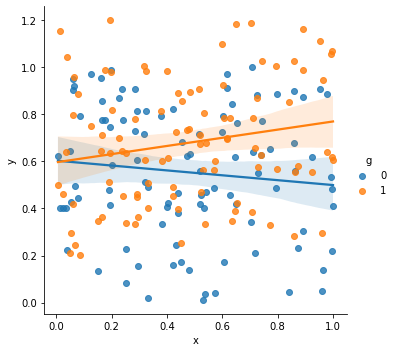

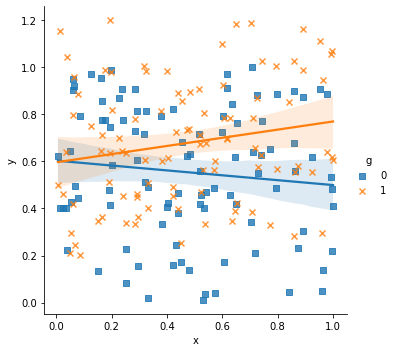

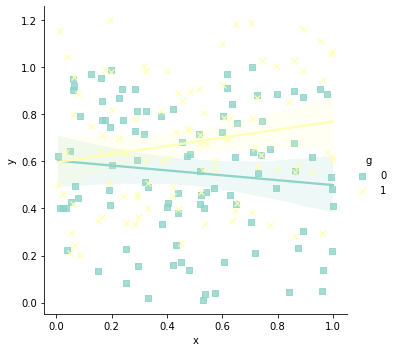

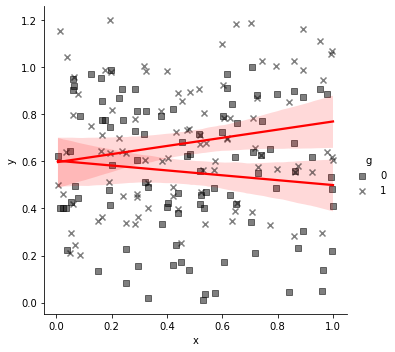

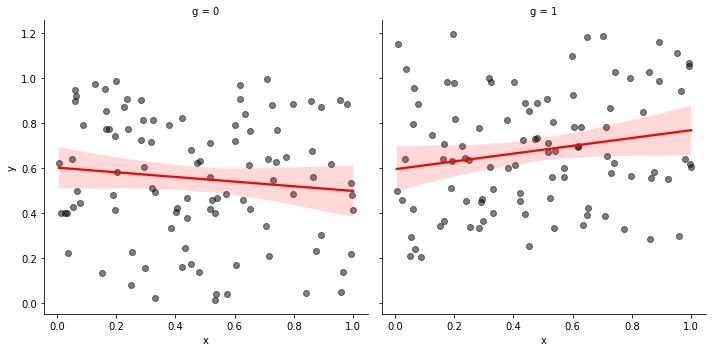

In [67]:
# Ez majd ahhoz kell amikor a két féle (old) (new) m' becslést összehasonlítom

t = pd.DataFrame()

x1 = np.random.rand(100)
x2 = x1.copy()
y1 = np.random.rand(100)
y2 = np.random.rand(100)+0.2

x12 = np.hstack((x1, x2))
y12 = np.hstack((y1, y2))

g1 = np.full(100, 0)
g2 = np.full(100, 1)
g12 = np.hstack((g1, g2))

t['x'] = x12
t['y'] = y12
t['g'] = g12

sns.lmplot(x = 'x', y = 'y', hue = 'g', data = t)

sns.lmplot(x = 'x', y = 'y',
           hue = 'g', markers = ["s", "x"], data = t)

sns.lmplot(x = 'x', y = 'y', palette = "Set3",
           hue = 'g', markers = ["s", "x"], data = t)

sns.lmplot(x = 'x', y = 'y',
           palette = "Set2",
           hue = 'g',
           markers = ["s", "x"],
           scatter_kws = {"color": "black", "alpha": 0.5},
           line_kws = {"color": "red"},
           data = t)

sns.lmplot(x = 'x', y = 'y',
           col = 'g', hue = 'g',
           scatter_kws = {"color": "black", "alpha": 0.5},
           line_kws = {"color": "red"},
           data = t)

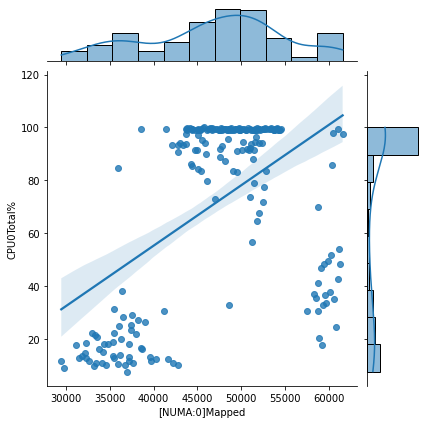

In [68]:
sns.jointplot(x='[NUMA:0]Mapped', y='CPU0Total%', data=mf, kind='reg');

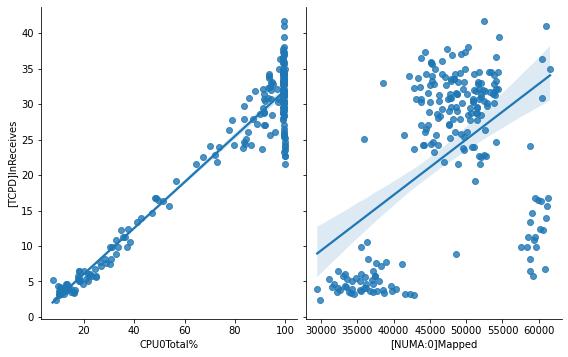

In [69]:
sns.pairplot(mf, x_vars=['CPU0Total%', '[NUMA:0]Mapped'], y_vars=['[TCPD]InReceives'],
             height=5, aspect=.8, kind='reg');

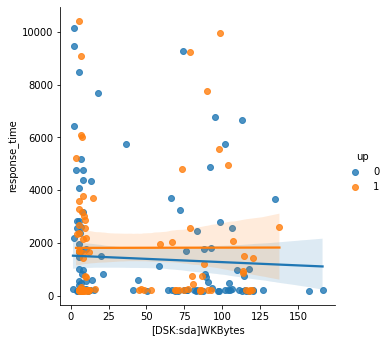

In [76]:
mf['up'] = [1 if x > 0 else 0 for x in mf['delta_vm']]

g = sns.pairplot(mf,
                 x_vars=['[DSK:sda]WKBytes'],
                 y_vars=['response_time'],
                 hue='up',
                 height=4.8, aspect=1.0, kind='reg')

# g.fig.set_size_inches(6.4, 6.4)

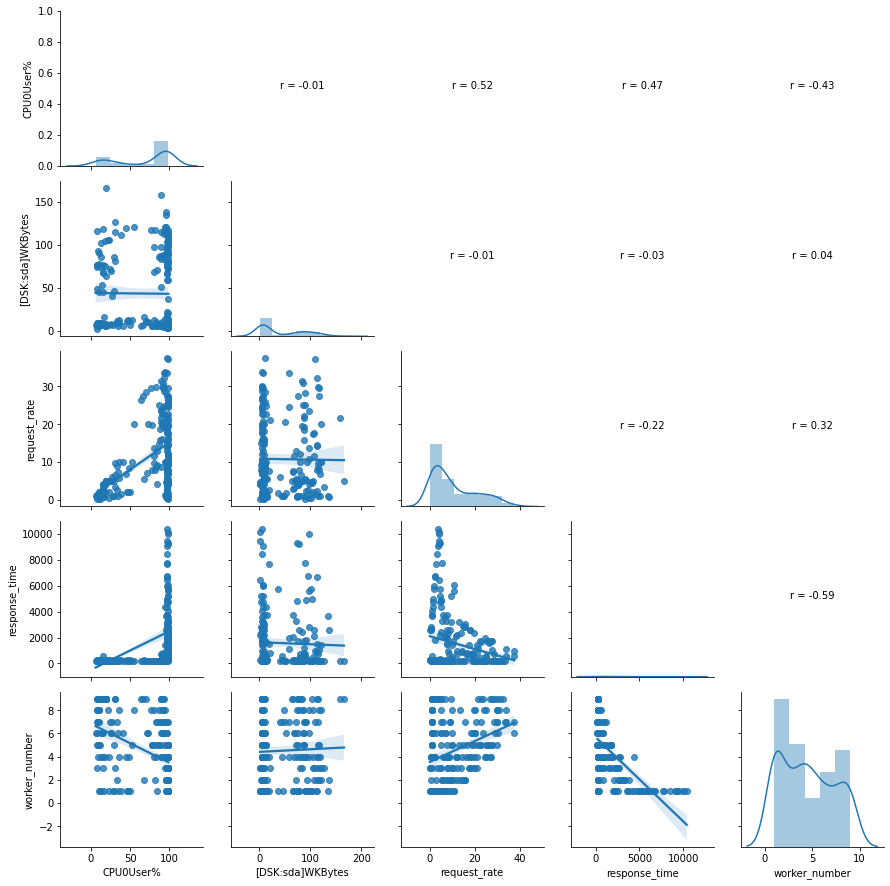

In [77]:
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

data = mf[input_variables]
g = sns.PairGrid(data)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

In [78]:
pf = mf.copy()

pf['rr10'] = pf['request_rate'].rolling(10).mean()
pf['rt10'] = pf['response_time'].rolling(10).mean()
pf['rr5std'] = pf['request_rate'].rolling(5).std()

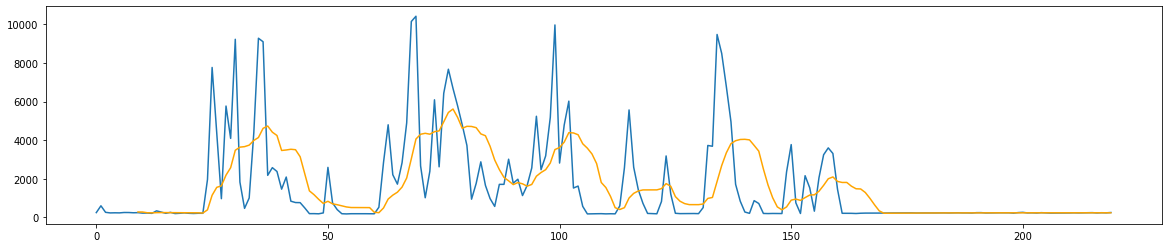

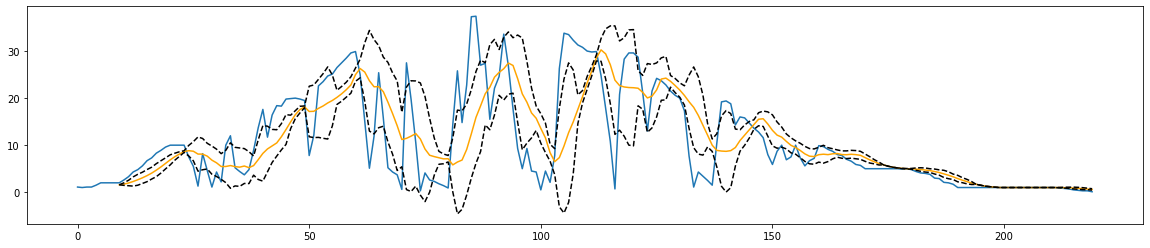

In [79]:
plt.figure(figsize=(20,4))
plt.plot(pf['response_time'])
plt.plot(pf['rt10'], color='orange')
plt.show()

plt.figure(figsize=(20,4))
plt.plot(pf['request_rate'])
plt.plot(pf['rr10'], color='orange')
plt.plot(pf['rr10'] + pf['rr5std'], color='black', ls='--')
plt.plot(pf['rr10'] - pf['rr5std'], color='black', ls='--')
plt.show()

  variable      value      species
0     leaf  11.871913  A. tauschii
1     leaf  16.013749  A. tauschii
2     leaf  11.930841  A. tauschii
3     leaf  14.794698  A. tauschii
4     leaf   8.642995  A. tauschii


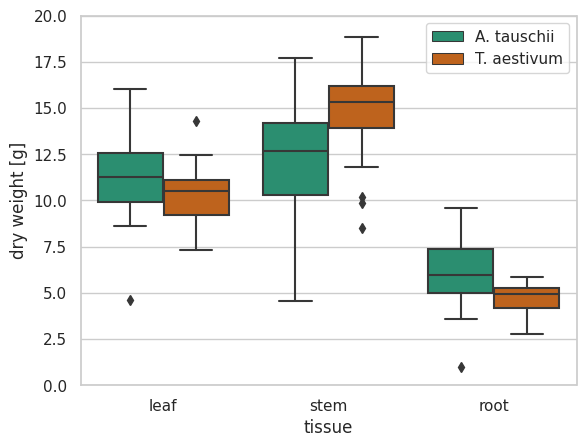

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')

np.random.seed(2018)

# data of Ta (T. aestivum) group
dfTa = pd.DataFrame({
    'leaf': np.random.normal(10, 2, 20),
    'stem': np.random.normal(15, 3, 20),
    'root': np.random.normal(5, 1, 20)
})

# data of At (A. tauschii) group
dfAt = pd.DataFrame({
    'leaf': np.random.normal(12, 3, 20),
    'stem': np.random.normal(12, 3, 20),
    'root': np.random.normal(6, 2, 20)
})

# merge the two data frames to one data frame
dfTa_melt = pd.melt(dfTa)
dfTa_melt['species'] = 'T. aestivum'
dfAt_melt = pd.melt(dfAt)
dfAt_melt['species'] = 'A. tauschii'

df = pd.concat([dfAt_melt, dfTa_melt], axis=0)
print(df.head())
##   variable      value      species
## 0     leaf  11.871913  A. tauschii
## 1     leaf  16.013749  A. tauschii
## 2     leaf  11.930841  A. tauschii
## 3     leaf  14.794698  A. tauschii
## 4     leaf   8.642995  A. tauschii

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='variable', y='value', data=df, hue='species', palette='Dark2', ax=ax)

ax.set_xlabel('tissue')
ax.set_ylabel('dry weight [g]')
ax.set_ylim(0, 20)
ax.legend()

plt.show()

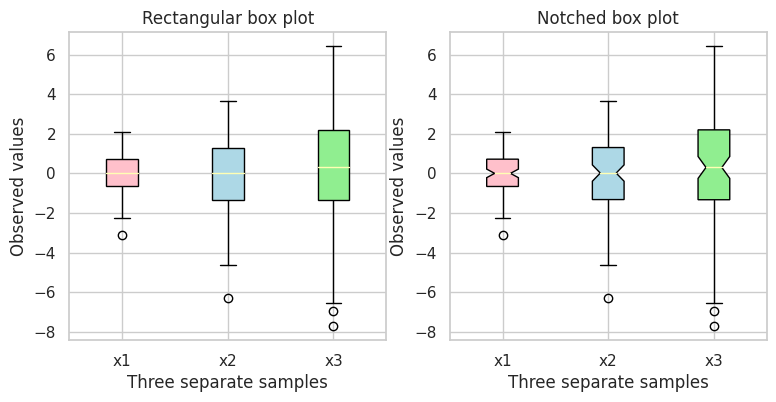

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Random test data
np.random.seed(19680801)
all_data = [np.random.normal(0, std, size=100) for std in range(1, 4)]
labels = ['x1', 'x2', 'x3']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = axes[0].boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[0].set_title('Rectangular box plot')

# notch shape box plot
bplot2 = axes[1].boxplot(all_data,
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[1].set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Observed values')

plt.show()

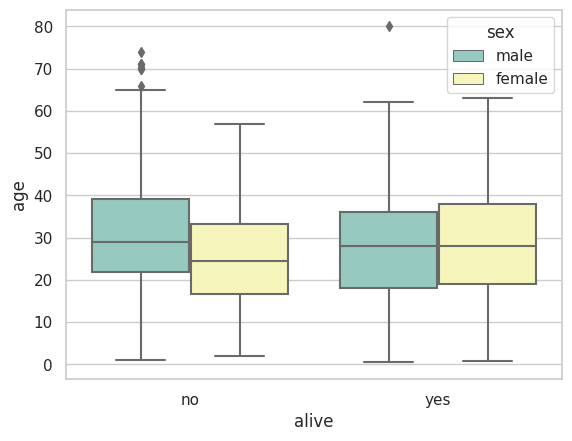

In [83]:
titanic_dataset = sns.load_dataset("titanic")
titanic_dataset.head()

sns.boxplot(x='alive', y='age', hue='sex', data=titanic_dataset)

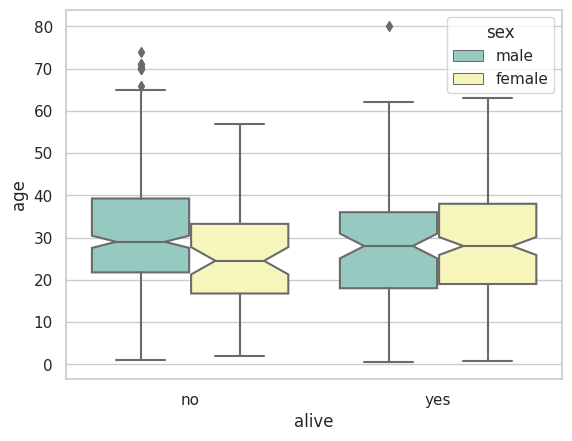

In [84]:
sns.boxplot(x='alive', y='age', hue='sex', notch= True, data=titanic_dataset)

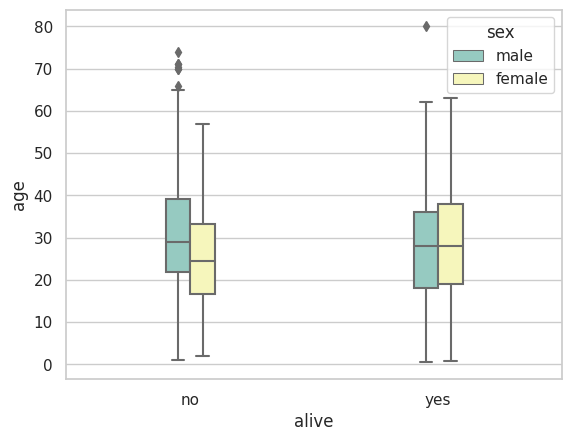

In [85]:
sns.boxplot(x='alive', y='age', hue='sex', width= 0.2, data=titanic_dataset)

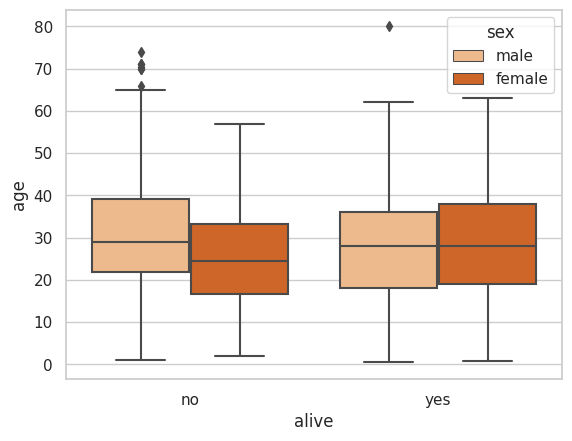

In [86]:
sns.boxplot(x='alive', y='age', hue='sex', data=titanic_dataset, palette="Oranges")

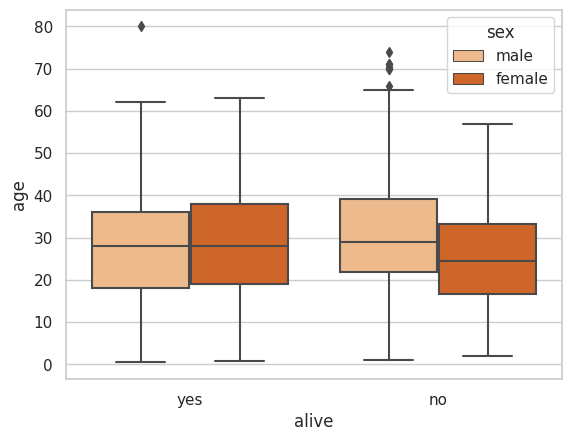

In [87]:
sns.boxplot(x='alive', y='age', hue='sex', order = ["yes", "no"] , data=titanic_dataset, palette="Oranges")